In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.patches import Rectangle
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.metrics import r2_score

# Set model parameters

In [ ]:
# Number of timesteps we want to look into the future based on the past 
# timesteps.
FORECAST_STEP = 1
# Number of past timesteps we want to use to predict the future.
WINDOW_SIZE = 5
TRAIN_RATIO = 0.8
EPOCHS = 10
BATCH_SIZE = 16
FEATURE_SELECTION = True
NUM_FEATURES = 5

# Load data

In [ ]:
#Import Train Dataset
dir_path = "drive/MyDrive/ROBOD/"
# Beehub, DIC, ER1, ER2, IRC
room_name = "IRC"
filename = "combined_{}_imputed.csv".format(room_name)

# Data preprocessing

In [ ]:
model_results = {}
for num_features in list(np.arange(1, 5)) + list(np.arange(5, 65, 5)):
  for i in range(5):
    data = pd.read_csv(dir_path + filename)

    # Extract hour information
    data[["date","time","utc_offset"]] = data["timestamp"].str.split(' ',expand=True)
    data[["hour","minute"]] = data["time"].str.split(':',expand=True)
    data = pd.concat([data, pd.get_dummies(data["hour"], dtype=float, prefix="hour")], axis=1)

    # Drop redundant columns
    redundant_cols = ["date", "time", "utc_offset", "minute", "occupant_presence", "hour"]
    data = data.drop(columns=redundant_cols)

    # Shift "occupancy_count" to the first column
    original_col_seq = list(data.columns)
    original_col_seq.remove("occupant_count")
    original_col_seq.remove("timestamp")
    data = data[["timestamp", "occupant_count"] + original_col_seq]
    
    #Choosing Training variables 
    cols = list(data)[1:]

    #Converting all variables into float
    df_for_training = data[cols].astype(float)
    df_for_training.head()

    if FEATURE_SELECTION:
      feature_selection_score = pd.read_csv(dir_path + "/Feature Selection and Importance/combined_feature_selection_{}.csv".format(room_name))
      top_n_features = feature_selection_score["feature"].tolist()[:num_features]
      df_for_training = df_for_training[["occupant_count"] + top_n_features]

    # perform feature scaling
    scaler = StandardScaler()
    scaler = scaler.fit(df_for_training)
    df_for_training_scaled = scaler.transform(df_for_training)

    # perform train test split
    X = []
    Y = []

    #Reformat input data into a shape: (n_samples x timesteps x n_features)
    for i in range(WINDOW_SIZE, len(df_for_training)-FORECAST_STEP+1):
      X.append(df_for_training_scaled[i-WINDOW_SIZE:i, :])
      Y.append(df_for_training_scaled[i+FORECAST_STEP-1, 0])

    trainX = X[:int(len(X) * TRAIN_RATIO)]
    testX = X[int(len(X) * TRAIN_RATIO):]
    trainY = Y[:int(len(Y) * TRAIN_RATIO)]
    testY = Y[int(len(Y) * TRAIN_RATIO):]
        
    trainX, trainY = np.array(trainX), np.array(trainY).reshape(-1,1)
    testX, testY = np.array(testX), np.array(testY).reshape(-1,1)

    input_size = trainX.shape[2]-1

    # Creating the model
    model = Sequential()
    model.add(Bidirectional(
        LSTM(32,
            activation="relu", 
            return_sequences=True)))
    model.add(Bidirectional(
        LSTM(32,
            activation="relu", 
            return_sequences=True)))
    model.add(Bidirectional(
        LSTM(32,
            activation="relu", 
            return_sequences=False)))
    model.add(Dense(1))

    model.compile(
        loss=tf.keras.losses.mse,
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
        metrics=["mae"]
    )

    # fit the model
    history = model.fit(trainX, 
                        trainY, 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE, 
                        validation_split=0.1, 
                        verbose=1)
    
    # Compare actual and predicted test values
    y_preds = model.predict(testX)

    # Inverse transformation
    prediction_copies = np.repeat(y_preds, df_for_training.shape[1], axis=-1)
    test_predictions = scaler.inverse_transform(prediction_copies)[:,0]

    testY_copies = np.repeat(testY, df_for_training.shape[1], axis=-1)
    testY = scaler.inverse_transform(testY_copies)[:,0]

    test_results = pd.DataFrame(data={'Test Predictions':np.round(test_predictions), 
                                      'Actuals':testY})

    ## Evaluate the model predictions
    mae = tf.metrics.mean_absolute_error(y_true=testY, y_pred=test_predictions)  
    rmse = tf.sqrt(tf.metrics.mean_squared_error(y_true=testY, y_pred=test_predictions))
    r2 = r2_score(y_true=testY, y_pred=test_predictions)
  
    if input_size not in model_results:
      model_results[input_size] = {"MAE":[], "RMSE":[], "R2":[]}
    model_results[input_size]["MAE"].append(mae.numpy())
    model_results[input_size]["RMSE"].append(rmse.numpy())
    model_results[input_size]["R2"].append(r2)
    
    del model


Epoch 1/10
609/609 [==============================] - 28s 19ms/step - loss: 0.1404 - mae: 0.1980 - val_loss: 0.0919 - val_mae: 0.1544
Epoch 2/10
609/609 [==============================] - 8s 13ms/step - loss: 0.0609 - mae: 0.1309 - val_loss: 0.0354 - val_mae: 0.0831
Epoch 3/10
609/609 [==============================] - 8s 14ms/step - loss: 0.0572 - mae: 0.1244 - val_loss: 0.0316 - val_mae: 0.0888
Epoch 4/10
609/609 [==============================] - 8s 14ms/step - loss: 0.0550 - mae: 0.1213 - val_loss: 0.0312 - val_mae: 0.0942
Epoch 5/10
609/609 [==============================] - 8s 14ms/step - loss: 0.0538 - mae: 0.1197 - val_loss: 0.0358 - val_mae: 0.0827
Epoch 6/10
609/609 [==============================] - 8s 14ms/step - loss: 0.0530 - mae: 0.1166 - val_loss: 0.0299 - val_mae: 0.0827
Epoch 7/10
609/609 [==============================] - 8s 14ms/step - loss: 0.0534 - mae: 0.1169 - val_loss: 0.0373 - val_mae: 0.1094
Epoch 8/10
609/609 [==============================] - 9s 14ms/step -

In [ ]:
results_dict = {}
for k, v in model_results.items():
  results_dict[k] = [sum(v["MAE"])/len(v["MAE"]), 
                     max(v["MAE"]), 
                     min(v["MAE"]), 
                     sum(v["RMSE"])/len(v["RMSE"]), 
                     max(v["RMSE"]), 
                     min(v["RMSE"]),
                     sum(v["R2"])/len(v["R2"]), 
                     max(v["R2"]), 
                     min(v["R2"])]

results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=["MAE_mean","MAE_max","MAE_min",
                                                                           "RMSE_mean","RMSE_max","RMSE_min",
                                                                           "R2_mean","R2_max","R2_min"])
results_df = results_df.rename_axis('num_features').reset_index()
results_df.head()

,num_features,MAE_mean,MAE_max,MAE_min,RMSE_mean,RMSE_max,RMSE_min,R2_mean,R2_max,R2_min
0,1,0.192686,0.305562,0.120255,0.358520,0.415122,0.322585,0.888466,0.910979,0.852581
1,2,0.220578,0.306693,0.144539,0.379505,0.458320,0.329750,0.874694,0.906981,0.820304
2,3,0.152853,0.195477,0.114017,0.342727,0.386346,0.315236,0.898902,0.914989,0.872311
3,4,0.149656,0.176587,0.126135,0.330410,0.344171,0.320041,0.906512,0.912378,0.898667


In [ ]:
results_df.to_csv(dir_path + "Model Results/bidirectional_lstm_performance_vs_num_features_{}.csv".format(room_name), index=False)

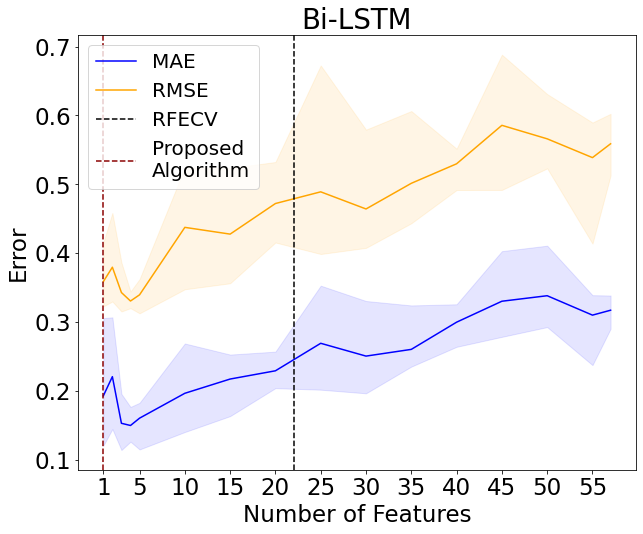

In [ ]:
room_name = "IRC"
results_df = pd.read_csv(dir_path + "Model Results/bidirectional_lstm_performance_vs_num_features_{}.csv".format(room_name))

space_type_mapping = {"Beehub":"Office",
                      "DIC":"Office",
                      "ER1":"Lecture Room",
                      "ER2":"Lecture Room",
                      "IRC":"Library"}

plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 23})

# Plot the MAE results
plt.plot(results_df["num_features"], results_df["MAE_mean"], color="blue", label="MAE")
# Plot the confidence interval
plt.fill_between(results_df["num_features"], results_df["MAE_min"], results_df["MAE_max"], color="blue", alpha=0.1)

# Plot the RMSE results
plt.plot(results_df["num_features"], results_df["RMSE_mean"], color="orange", label="RMSE")
# Plot the confidence interval
plt.fill_between(results_df["num_features"], results_df["RMSE_min"], results_df["RMSE_max"], color="orange", alpha=0.1)

# Indicate model performance based on RFECV 
rfecv_result = pd.read_csv(dir_path + "/Feature Selection and Importance/combined_feature_selection_{}.csv".format(room_name))
num_feature_selected_rfecv = len(rfecv_result[rfecv_result["ranking"]==1])
plt.axvline(x=num_feature_selected_rfecv, 
            ymin=0, ymax=5, color='black', linestyle="dashed", label="RFECV")

# Indicate model performance based on proposed feature selection algorithm
best_performance_idx = 0
for i in range(1, len(results_df)):
  if results_df.loc[i, "MAE_mean"] > results_df.loc[best_performance_idx, "MAE_mean"]:
    break
  else:
    best_performance_idx = i
plt.axvline(x=results_df.loc[best_performance_idx, "num_features"],
            ymin=0, ymax=5, color='#8b0000', linestyle="dashed", label="Proposed \nAlgorithm")

plt.legend(prop={'size': 20})
plt.xlabel("Number of Features")
plt.ylabel("Error")
xticks = [int(tick) for tick in results_df["num_features"].tolist() 
          if (tick % 5 == 0) or (tick == results_df.loc[best_performance_idx, 
                                                        "num_features"])]
# xticks.append(num_feature_selected_rfecv)
xticks.sort()
plt.xticks(ticks=xticks, labels=xticks)
plt.title("Bi-LSTM")
plt.savefig(dir_path + "Figures/bidirectional_lstm_performance_vs_num_features_{}.png".format(room_name), 
            dpi=600, bbox_inches="tight")
plt.show()